# A Simple Example with a Mortality Crisis #

This notebook allows you enact a mortality crisis upon a variety of simulations using either random or deterministic probabilities. 

We start by loading the households package:

In [1]:
import os
os.chdir('..')
from households import *
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

Importing the households package
Importing identity
importing kinship
importing residency
importing behavior
loading narrative
Importing main.py
importing inheritance
importing marriage
importing mobility


Only run this next line if you've made changes to the code and are needing to reload the package.

In [2]:
from households import *

## Scheduling life events ##

### For Random Scheduling ###
Men tend to marry later than women; women have a 10-year period of fertility; men and women both tend to live a long time if they survive childhood; and men and women can remarry gradually after they are widowed.


In [3]:
# Run these next five lines if using random scheduling.

age_of_majority = 19
eligibility = AgeTable(ages = [0,age_of_majority,100], sex1 = female, rates1 = [0,.5], sex2 = male, rates2 = [0,.25])
fertility = AgeTable(ages = [0,age_of_majority,age_of_majority+10,100], sex1 = female, rates1 = [0,.65,0], sex2 = male, rates2 = [0,0,0])
mortality = AgeTable(ages=[0,5,20,50,70,100], sex1 = male, rates1 = [.1,.01,0,.05,.5], sex2 = female, rates2 = [.1,.01,0,.05,.5])
remarriage = AgeTable(ages = [0,age_of_majority,100], sex1 = female, rates1 = [0,.1], sex2 = male, rates2 = [0,.1])

### For Deterministic Scheduling ###
Everyone gets married at age 20, has up to four children, and dies at age 60. To accomplish this, we define AgeTables for eligibility (starting at an age of majority such that everyone achieves eligibility at 19 to be married at age 20 if sufficient partners exist), fertility (four years max of potential fertility when married), and mortality (univerally 1 starting at age 60, ensuring everyone dies then), with remarriage defined by an all-zero table.

In [4]:
# Run these next five lines if using deterministic scheduling.

#age_of_majority = 19
#eligibility = AgeTable(ages = [0,age_of_majority,100], sex1 = female, rates1 = [0,1], sex2 = male, rates2 = [0,1])
#fertility = AgeTable(ages = [0,age_of_majority,age_of_majority+5,100], sex1 = female, rates1 = [0,1,0], sex2 = male, rates2 = [0,0,0])
#mortality = AgeTable(ages=[0,60,100],sex1 = male, rates1 = [0,1], sex2 = female, rates2 = [0,1])
#remarriage = AgeTable.NullAgeTable()

All of these AgeTables need to be inserted into the appropriate syntax: in the case of mortality and fertility rates, these are still given directly to the starting community of `Persons`, while eligibility and remarriage are actually part of a `MarriageRule` that gets passed from the community to individual people.

The three rules that we have to define are, at present, a `MarriageRule`, a `MobilityRule`, and an `InheritanceRule`. We treat these each in turn.


### `MarriageRule`: Pick a random, single, eligible spouse

The `MarriageRule` we will implement will use the `eligibility` and `remarriage` schedules above and then define what is involved in finding and marrying a spouse via the defined functions in `behavior.marriage`. In particular, we need to define:

    1. who is considered a potential spouse,
    2. how we will pick among the selection of spouses, and 
    3. where newlyweds live

We define an eligible partner as any single, eligible (`unmarried`), non-sibling in the same community using `get_eligible_not_sibling_same_community`. We pick a spouse at random from the selection (`pick_spouse_random`) and then attempt to move the new couple in with the husband's family if there is space; otherwise they move to a new house (`locality_patrilocality`).

### `MobilityRule`: Adult children leave a household with their nuclear family if it gets overcrowded

The `MobilityRule` we will create will check whether an adult is living in an overcrowded house they don't own, and then move them with their spouse and children to a new house. There exists a default function to check whether a household is overcrowded (`check_household_overcrowded`), but we need to create a new function that combines this with the age check and the ownership check. We will call this function `check_household_nonowner_adult_man_overcrowded` to keep the nomenclature consistent. We then use the existing `who_leaves_house_family` to identify their family and `destination_random_house_same_village` to find a new house to move them to.

### `InheritanceRule`: Let sons and then brothers' sons inherit houses, but only own one

The `InheritanceRule` will be to check the male line of a family, starting with male children and followed by brothers' sons. We implement this by using the `find_heirs_multiple_constructor`, which combines multiple `find_heirs` functions into a single ordered list. We call this new function `find_heirs_sons_then_brothers_sons` and use it to defined the heirs of a person with a house to be inherited (`has_property_houses`). We then limit all heirs to lack property before inheritance (`limit_heirs_not_owners`), and say that the first heir in the list (who is therefore likely the oldest son or oldest brother's older son without a house) will be the one to inherit (`distribute_property_to_first_heir_and_move_household`). If inheritance fails, the house defaults to no owner, and once all family members leave or die it will default to no ownership (`failed_inheritance_no_owner`). 

### `BirthRule`: Use the fertility schedule without infanticide or maternal death

Using the AgeTable for fertiltiy above, the `BirthRule` just passes this as the fertility for a married woman, with fertility for an unmarried woman defined as a NullAgeTable (always 0). The sex ratio is 50-50, and  infanticide is not a factory. 15% of women die during childbirth.

In [5]:
#The MarriageRule
marriagerule = behavior.marriage.MarriageRule(eligibility_agetable = eligibility, #defined above
                                              get_eligible = behavior.marriage.get_eligible_not_sibling_same_community,
                                              #find all single individuals in the village who aren't siblings
                                              pick_spouse = behavior.marriage.pick_spouse_random, #pick a random spouse
                                              locality = behavior.marriage.locality_patrilocality, #patrilocality
                                              remarriage_agetable = remarriage #defined above
                                             )

#The MobilityRule
def check_household_nonowner_adult_man_overcrowded(person):
    """Check that the household is overcrowded and that this person is not the owner and an adult."""
    overcrowded = behavior.mobility.check_household_overcrowded(person) #check overcrowding but also assert
    ## that there is indeed a house to check
    if overcrowded:
        if person.age >= age_of_majority and person not in person.has_house.get_owners() and person.sex == identity.male:
            #If above or at the age of majority and the person is a man who is not the owner of the house they live in
            return True
    return False

mobilityrule = behavior.mobility.MobilityRule(check_household = check_household_nonowner_adult_man_overcrowded,
                                                   who_leaves_house = behavior.mobility.who_leaves_house_family,
                                                   destination = behavior.mobility.destination_random_house_same_village)
#The InheritanceRule
#Our custom function to check sons then brothers' sons;
## note the use of lambda to make find_heirs_siblings_children into a single parameter function in order to define
## the sex as male.
find_heirs_sons_then_brothers_sons = behavior.inheritance.find_heirs_multiple_constructor(behavior.inheritance.find_heirs_sons_oldest_to_youngest,
                                                     lambda p: behavior.inheritance.find_heirs_siblings_children_oldest_to_youngest(p,sex = identity.male))


inheritancerule = behavior.inheritance.InheritanceRuleComplex(has_property = behavior.inheritance.has_property_houses,
                                                                    find_heirs = find_heirs_sons_then_brothers_sons,
                                                                    limit_heirs = behavior.inheritance.limit_heirs_not_owners,
                                                                    distribute_property = behavior.inheritance.distribute_property_to_first_heir_and_move_household,
                                                                    failure = behavior.inheritance.failed_inheritance_no_owner)

birthrule = behavior.conception.BirthRule(marriedbirth = fertility,
                                         unmarriedbirth = AgeTable.NullAgeTable(),
                                         femalesexratio = .5,
                                         maternaldeath = behavior.conception.maternal_death_zero,
                                         infanticide = behavior.conception.infanticide_none)

## Setup for a Mortality Crisis ##

For a mortality crisis to be carried out, we need to first define the annual mortality rate. This an average across the entire population and it must be adjusted to account for all ages and household sizes. 

After an annual mortality rate is defined as `base_rate`, it is inserted into 3 lists of mortality rates for household sizes of 5 or less, 5 to 10, and more than 10. It is then increased by a multiplier to account for age ranges of 0 to 20, 20 to 60, and 60 to 100. 

Next, each list of mortality rates is placed within a corresponding `AgeTable` for each household size. Each `AgeTable` is then put into a list of Agetables called `plaguetab` which will be used as a parameter when defining a `MortalityCrisis` and be accessed by that `MortalityCrisis` when the it evaluates each `Person`.

Various annual mortality rates have been derived at the end of this notebook.

In [6]:
base_rate = 0.0138 #base annual fatality rate, currently set to 1.38% to represent a densely populated urban environment

rates_hsize_5orless = [base_rate*1.25, base_rate, base_rate*1.25]
rates_hsize_5to10 = [(base_rate*1.5), base_rate*1.25, (base_rate*1.5)]
rates_hsize_morethan10 = [base_rate*1.75,base_rate*1.5, base_rate*1.75]

at_hsize_5orless = AgeTable(ages = [0,20,60,100],sex1 = female, rates1 = rates_hsize_5orless, sex2 = male, rates2 = rates_hsize_5orless)
at_hsize_5to10 = AgeTable(ages = [0,20,60,100],sex1 = female, rates1 = rates_hsize_5to10, sex2 = male, rates2 = rates_hsize_5to10)
at_hsize_morethan10 = AgeTable(ages = [0,20,60,100],sex1 = female, rates1 = rates_hsize_morethan10, sex2 = male, rates2 = rates_hsize_morethan10)

plaguetab = [at_hsize_5orless, at_hsize_5to10, at_hsize_morethan10]

## Simulation Run without Plague ##

With all of these functions defined, we can now create the `World` of the simulation and our sole `Community`, Sweetwater.

In [7]:
start_pop = 100 #just a few people to start
start_area = 4000 #lots of room for growth
start_age = age_of_majority - 1 #so that everyone makes the transition to marriage eligibility on time
pophistory = []

rd.seed(3442) #Used here to standardize the example code across runs for any random parts like name generation.
terra = World()
sweetwater = Community(world = terra,
                       name = 'Sweetwater',
                       pop = start_pop,
                       area = start_area,
                       startage = start_age,
                       mortab = mortality,
                       birthtab = fertility,
                       marriagerule = marriagerule,
                       inheritancerule = inheritancerule,
                       mobilityrule = mobilityrule,
                       birthrule = birthrule)


We can now run the simulation.

In [8]:
while terra.year < 150: #run for however many years
    terra.progress()
    pophistory.append(len(terra.people))
print('Current year: '+ str(terra.year))
print('Ending Population: ' + str(len(terra.people)))
#print(pophistory)

Current year: 150
Ending Population: 863


Here we can see population through time as well as variation in household types at the end of the simulation run.

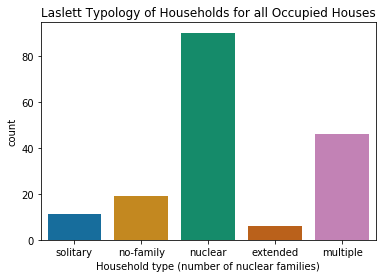

In [9]:
sns.countplot([residency.classify(h) for h in terra.houses if h.people != []], order = ['solitary','no-family','nuclear','extended','multiple'], palette = 'colorblind')
plt.title('Laslett Typology of Households for all Occupied Houses')
plt.xlabel('Household type (number of nuclear families)')
print('')

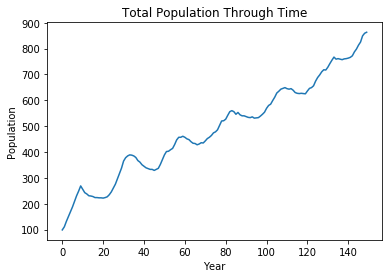

In [10]:
x_years = list(range(terra.year))
y_pop1 = pophistory
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Total Population Through Time')
plt.plot(x_years, y_pop1)

We can also view births, marriages, and deaths through time.

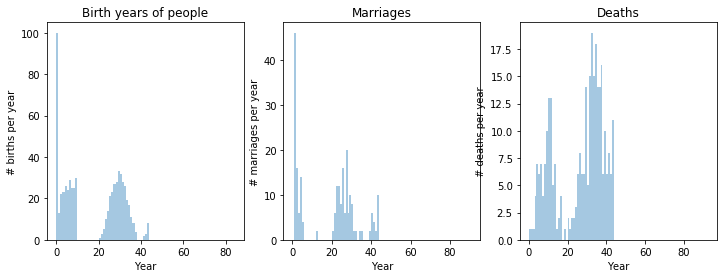

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))
#sns.set_style("whitegrid")
sns.distplot([min(d.get_events().keys()) for d in terra.library['Person']], kde = False, bins = range(45), ax = ax1)
ax1.set_title("Birth years of people")
#plt.subtitle("Third generation is normally distributed.")
ax1.set_xlabel("Year")
ax1.set_ylabel("# births per year")

sns.distplot([l.year for i in range(len(terra.library['Person'])) for x in terra.library['Person'][i].get_events().items() for l in x[1] if isinstance(l,narrative.MarriageEvent)]
             , kde = False, bins = range(45), ax = ax2)
ax2.set_title("Marriages")
#ax2.subtitle("Third generation is normally distributed.")
ax2.set_xlabel("Year")
ax2.set_ylabel("# marriages per year")

sns.distplot([l.year for i in range(len(terra.library['Person'])) for x in terra.library['Person'][i].get_events().items() for l in x[1] if isinstance(l,narrative.DeathEvent)],
             kde = False, bins = range(45), ax = ax3)
ax3.set_title("Deaths")
#ax2.subtitle("Third generation is normally distributed.")
ax3.set_xlabel("Year")
ax3.set_ylabel("# deaths per year")


print('')
#plt.hist([min(d.get_events().keys()) for d in terra.library['Person']], bins = range(45))

In addition to viewing the entire world, we can also use the tools in narrative to explore single individuals and their households.

In [13]:
#Run this first to pick a random house
h = rd.choice([x for x in sweetwater.houses if len(x.people) >= 2])#pick a house with at least two people in it to make it interesting

In [14]:
#Now run this to see the output
print('The house at ' + h.address + ' contains ' + narrative.census(h)+':')
for x in h.people:
    print(narrative.biography(x)) 
print(' ')


The house at 57 Cactus Court contains a multiple household with 11 people residing owned by Logan (1.0 shares):
Lawrence is a living man, 31 years old, married with 4 children
Arnold is a living man, 25 years old, married with 4 children
Ashley is a living woman, 29 years old, married with 4 children
Maeve is a living woman, 7 years old, ineligible
Maeve is a living woman, 4 years old, ineligible
Jasmyn is a living woman, 24 years old, married with 4 children
Theresa is a living woman, 3 years old, ineligible
Lawrence is a living man, 3 years old, ineligible
Ashley is a living woman, 2 years old, ineligible
Elsie is a living woman, 1 year old, ineligible
Lawrence is a living man, 0 years old, ineligible
 


In [15]:
#Here is some space to explore the currently selected household, if you want.

strange = [h for h in terra.houses if len([p for p in h.people if p in h.get_owners()]) == 0 and len(h.people) > 0]
i = 0
print(strange[i].address + ': ' + narrative.census( strange[i]))
o = strange[i].get_owners()[0]
print(narrative.biography(o))
#who lives there?
for p in strange[i].people:
    print(narrative.biography(p))
    print(p in kinship.get_siblings(o))
    print(p in kinship.get_children(o))


27 Tavern Trail: a multiple household with 8 people residing owned by Lawrence (1.0 shares)
Lawrence is a dead man, 4 years old, ineligible
Clementine is a living woman, 49 years old, widowed with 8 children
False
False
Robert is a living man, 28 years old, married with 3 children
False
False
Arnold is a living man, 27 years old, married with no children
False
False
Theresa is a living woman, 37 years old, widowed with one child
False
False
Dolores is a living woman, 49 years old, married with 5 children
False
False
Dolores is a living woman, 23 years old, married with 3 children
False
False
Bernard is a living man, 2 years old, ineligible
False
False
Charlotte is a living woman, 0 years old, ineligible
False
False


In [16]:
f = [p for p in kinship.get_parents(o) if p.sex == identity.male][0]

print([e.summary() for l in o.diary.get_events().items() for e in l[1] if e.house is not None]) # 

['Year 135: Lawrence was born at 27 Tavern Trail, Sweetwater', 'Year 135: Lawrence moved into 27 Tavern Trail, Sweetwater', 'Year 140: Lawrence died at 27 Tavern Trail, Sweetwater', 'Year 140: Lawrence left 27 Tavern Trail, Sweetwater']


## Simulation Run with Plague ##

All parameters are the same as the previous simulation with the addition of a plague mortality crisis.

In [17]:
start_pop = 100 #just a few people to start
start_area = 4000 #lots of room for growth
start_age = age_of_majority - 1 #so that everyone makes the transition to marriage eligibility on time
plague = MortalityCrisis(75, 10, plaguetab) #create a plague to enact upon simulation at year 75 for 10 time steps
pop_each_year = []

rd.seed(3442) #Used here to standardize the example code across runs for any random parts like name generation.
terra = World()
sweetwater = Community(world = terra,
                       name = 'Sweetwater',
                       pop = start_pop,
                       area = start_area,
                       startage = start_age,
                       mortab = mortality,
                       birthtab = fertility,
                       marriagerule = marriagerule,
                       inheritancerule = inheritancerule,
                       mobilityrule = mobilityrule,
                       birthrule = birthrule)


We can now run the simulation.

In [18]:

while terra.year < 150: #run for however many years
    plague(terra) #place plague within simulation
    terra.progress()
    pop_each_year.append(len(terra.people))
print('Current year: '+ str(terra.year))
print('Number killed by plague: ' + str(len(plague.killedbyplague)))
print('Ending Population: ' + str(len(terra.people)))
#print(pop_each_year_base)

Current year: 150
Number killed by plague: 92
Ending Population: 681


Here we can see population through time as well as variation in household types at the end of the simulation run.

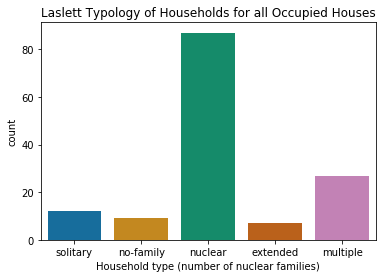

In [19]:
sns.countplot([residency.classify(h) for h in terra.houses if h.people != []], order = ['solitary','no-family','nuclear','extended','multiple'], palette = 'colorblind')
plt.title('Laslett Typology of Households for all Occupied Houses')
plt.xlabel('Household type (number of nuclear families)')
print('')

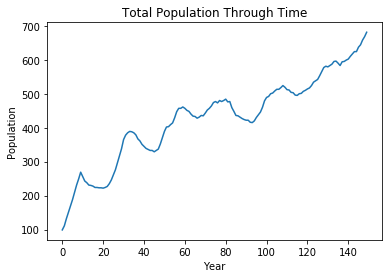

In [20]:
x_years = list(range(terra.year))
y_pop1 = pop_each_year
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Total Population Through Time')
plt.plot(x_years, y_pop1)

We can also view births, marriages, and deaths through time.

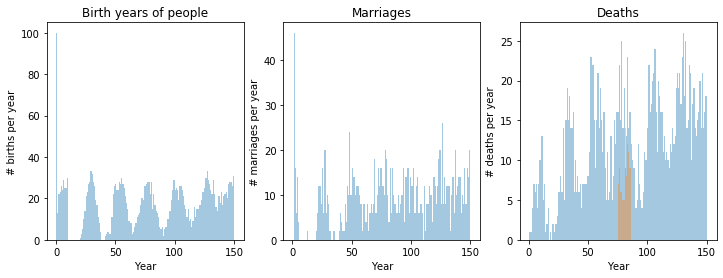

In [21]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))
#sns.set_style("whitegrid")
sns.distplot([min(d.get_events().keys()) for d in terra.library['Person']], kde = False, bins = range(terra.year+2), ax = ax1)
ax1.set_title("Birth years of people")
#plt.subtitle("Third generation is normally distributed.")
ax1.set_xlabel("Year")
ax1.set_ylabel("# births per year")

sns.distplot([l.year for i in range(len(terra.library['Person'])) for x in terra.library['Person'][i].get_events().items() for l in x[1] if isinstance(l,narrative.MarriageEvent)]
             , kde = False, bins = range(terra.year+2), ax = ax2)
ax2.set_title("Marriages")
#ax2.subtitle("Third generation is normally distributed.")
ax2.set_xlabel("Year")
ax2.set_ylabel("# marriages per year")

sns.distplot([l.year for i in range(len(terra.library['Person'])) for x in terra.library['Person'][i].get_events().items() for l in x[1] if terra.library['Person'][i].associated not in plague.killedbyplague and isinstance(l,narrative.DeathEvent)],
             kde = False, bins = range(terra.year+2), ax = ax3)
sns.distplot([l.year for i in range(len(terra.library['Person'])) for x in terra.library['Person'][i].get_events().items() for l in x[1] if terra.library['Person'][i].associated in plague.killedbyplague and isinstance(l,narrative.DeathEvent)],
             kde = False, bins = range(terra.year+2), ax = ax3)
ax3.set_title("Deaths")
#ax2.subtitle("Third generation is normally distributed.")
ax3.set_xlabel("Year")
ax3.set_ylabel("# deaths per year")


print('')

In addition to viewing the entire world, we can also use the tools in narrative to explore single individuals and their households.

In [22]:
#Run this first to pick a random house
h = rd.choice([x for x in sweetwater.houses if len(x.people) >= 2])#pick a house with at least two people in it to make it interesting

In [23]:
#Now run this to see the output
print('The house at ' + h.address + ' contains ' + narrative.census(h)+':')
for x in h.people:
    print(narrative.biography(x)) 
print(' ')

The house at 27 Cattle Drive contains a nuclear household with 7 people residing owned by Lee (1.0 shares):
Lee is a living man, 35 years old, married with 6 children
Maeve is a living woman, 29 years old, married with 6 children
Bernard is a living man, 9 years old, ineligible
Lee is a living man, 8 years old, ineligible
Ashley is a living woman, 5 years old, ineligible
Emily is a living woman, 2 years old, ineligible
Maeve is a living woman, 1 year old, ineligible
 


In [24]:
#Here is some space to explore the currently selected household, if you want.

strange = [h for h in terra.houses if len([p for p in h.people if p in h.get_owners()]) == 0 and len(h.people) > 0]
i = 0
print(strange[i].address + ': ' + narrative.census( strange[i]))
o = strange[i].get_owners()[0]
print(narrative.biography(o))
#who lives there?
for p in strange[i].people:
    print(narrative.biography(p))
    print(p in kinship.get_siblings(o))
    print(p in kinship.get_children(o))


47 Main Street: a nuclear household with 8 people residing owned by Teddy (1.0 shares)
Teddy is a living man, 54 years old, married with 8 children
Charlotte is a living woman, 29 years old, widowed with 5 children
False
False
Lawrence is a living man, 8 years old, ineligible
False
False
William is a living man, 5 years old, ineligible
False
False
Robert is a living man, 32 years old, married with 8 children
False
True
Armistice is a living woman, 30 years old, married with 8 children
False
False
Hector is a living man, 5 years old, ineligible
False
False
Maeve is a living woman, 3 years old, ineligible
False
False
Elsie is a living woman, 2 years old, ineligible
False
False


In [25]:
f = [p for p in kinship.get_parents(o) if p.sex == identity.male][0]

print([e.summary() for l in o.diary.get_events().items() for e in l[1] if e.house is not None]) # 

['Year 95: Teddy was born at 55 Cactus Court, Sweetwater', 'Year 95: Teddy moved into 55 Cactus Court, Sweetwater', 'Year 116: Teddy married Clementine at 55 Cactus Court, Sweetwater', 'Year 145: Teddy left 55 Cactus Court, Sweetwater', 'Year 145: Teddy left 47 Main Street, Sweetwater']


## Multiple Simulation Runs with Varying Seeds and Durations ##

In [26]:
killednum = []
durations = [5,10,15] #define list of durations to be used for each seed, simulation runtime increases heavily as list increases in length
seeds = [123, 456, 789] #define list of desired seeds to be iterated through

for d in durations: 
    for s in seeds:

        start_pop = 100 #just a few people to start
        start_area = 2000 #lots of room for growth
        start_age = age_of_majority - 1 #so that everyone makes the transition to marriage eligibility on time
        plague = MortalityCrisis(75, d, plaguetab) #create a plague to enact upon simulation at year 75 for d time steps

        rd.seed(s) #Used here to standardize the example code across runs for any random parts like name generation.
        terra = World()
        sweetwater = Community(world = terra,
                               name = 'Sweetwater',
                               pop = start_pop,
                               area = start_area,
                               startage = start_age,
                               mortab = mortality,
                               birthtab = fertility,
                               marriagerule = marriagerule,
                               inheritancerule = inheritancerule,
                               mobilityrule = mobilityrule,
                               birthrule = birthrule)
        while terra.year < 100: #run for however many years
            plague(terra) #place plague within simulation
            terra.progress()
        #write some history
        killednum.append(len(plague.killedbyplague))
print(killednum)


[44, 21, 41, 77, 34, 83, 108, 44, 115]


## Multiple Simulation Runs with Varying Annual Death Rates ##

In [27]:
pop_hist = [] #list of lists of population through time data for each simulation run
annual_rates = [0.0072, 0.0083, 0.0094, 0.0105, 0.0138, 0.0149, 0.0161] #annual death rates derived from

for r in annual_rates:
    br = r #base annual fatality rate from annual_rates
    
    rates_hsize_5orless = [br*1.25, br, br*1.25]
    rates_hsize_5to10 = [(br*1.5), br*1.25, (br*1.5)]
    rates_hsize_morethan10 = [br*1.75,br*1.5, br*1.75]

    at_hsize_5orless = AgeTable(ages = [0,20,60,100],sex1 = female, rates1 = rates_hsize_5orless, sex2 = male, rates2 = rates_hsize_5orless)
    at_hsize_5to10 = AgeTable(ages = [0,20,60,100],sex1 = female, rates1 = rates_hsize_5to10, sex2 = male, rates2 = rates_hsize_5to10)
    at_hsize_morethan10 = AgeTable(ages = [0,20,60,100],sex1 = female, rates1 = rates_hsize_morethan10, sex2 = male, rates2 = rates_hsize_morethan10)

    plaguetab = [at_hsize_5orless, at_hsize_5to10, at_hsize_morethan10]
    
    start_pop = 100 #just a few people to start
    start_area = 4000 #lots of room for growth
    start_age = age_of_majority - 1 #so that everyone makes the transition to marriage eligibility on time
    plague = MortalityCrisis(75, 10, plaguetab) #create a plague to enact upon simulation at year 75 for 10 time steps
    pop_each_year = []

    rd.seed(6788) #Used here to standardize the example code across runs for any random parts like name generation.
    terra = World()
    sweetwater = Community(world = terra,
                           name = 'Sweetwater',
                           pop = start_pop,
                           area = start_area,
                           startage = start_age,
                           mortab = mortality,
                           birthtab = fertility,
                           marriagerule = marriagerule,
                           inheritancerule = inheritancerule,
                           mobilityrule = mobilityrule,
                           birthrule = birthrule)
    while terra.year < 150: #run for 140 years
        plague(terra) #place plague within simulation
        terra.progress()
        pop_each_year.append(len(terra.people)) #create data for population over time
    pop_hist.append(pop_each_year) #add data for population over time to pop_hist
#print(pop_hist)
print(terra.year)


150


Population through time for all simulation runs

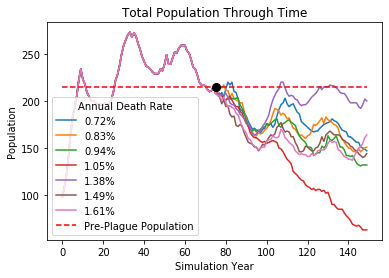

In [28]:

annual_rates_percent = ['0.72%', '0.83%', '0.94%', '1.05%', '1.38%', '1.49%', '1.61%']
x_years = list(range(terra.year))
plt.xlabel('Simulation Year')
plt.ylabel('Population')
plt.title('Total Population Through Time')

#plot population through time for each annual death rate
for i in range(len(pop_hist)):
    plt.plot(x_years, pop_hist[i], label = annual_rates_percent[i])

#Create list of values for pre-plague population line
y_pre_plague_pop = []
for i in range(terra.year):
   y_pre_plague_pop.append(pop_hist[0][plague.startyear-1])
plt.plot(x_years, y_pre_plague_pop, label = 'Pre-Plague Population', color = 'red', linestyle = '--')
    
#Data point of start of plague
plt.plot([plague.startyear], pop_hist[0][plague.startyear-1], marker = 'o', markersize = 8, color = 'black')

plt.legend(title = 'Annual Death Rate')


## Estimated Average Annual Death Rates for the Antonine Plague

Total fatality rates taken from:

Littman, R. J., and M. L. Littman. 1973. “Galen and the Antonine Plague.” The American Journal of Philology 94 (3): 243–55. https://doi.org/10.2307/293979.


Total Fatality Rate for Entire Empire: 7-10%
    
    7% - Avg Annual rate: 0.0072
    8% - Avg Annual rate: 0.0083
    9% - Avg Annual rate: 0.0094
    10% - Avg Annual rate: 0.0105

Total Fatality Rate for Entire Plague for Cities & Armies: 13-15%
    
    13% - Avg Annual rate: 0.0138
    14% - Avg Annual rate: 0.0149
    15% - Avg Annual rate: 0.0161


Calculations for Annual Death Rates

In [29]:
k = .07 #killed
nk = 1 - k #not killed
y = 10 #years
p = (nk) ** (1./y)
print(1-p)

0.007230800339783072


In [30]:
#misc
#individual households over time
#number of different households at different population levels